## Variable that changed a lot

In [1]:
Model_name = "alexnet"

run_num  = "2"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [2]:
tensor_baord_variable, path

('alexnet_2', 'CheckPoints/alexnet_2')

## Check the working environment

In [3]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [4]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [5]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [6]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [7]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [8]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [11]:
import os

In [12]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [13]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [14]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [19]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [20]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [21]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [22]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpg', 'jpeg'}


### Check corrupted images 

In [23]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [24]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [25]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [26]:
import matplotlib.pyplot as plt

In [27]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

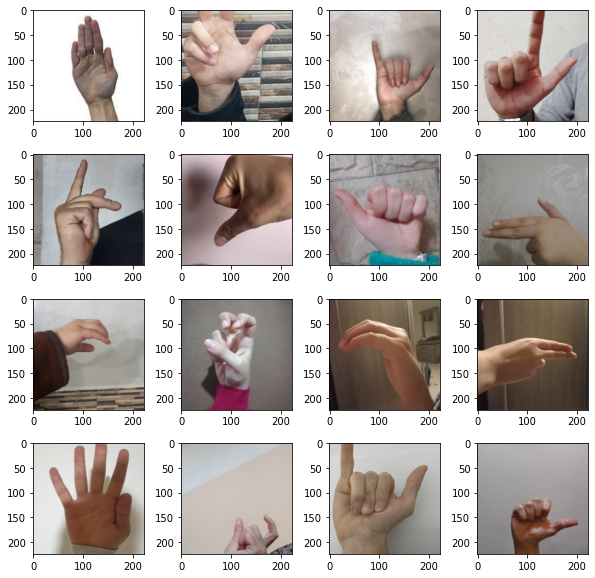

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [31]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [32]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [33]:
from collections import Counter
import numpy as np

In [34]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [35]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [36]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

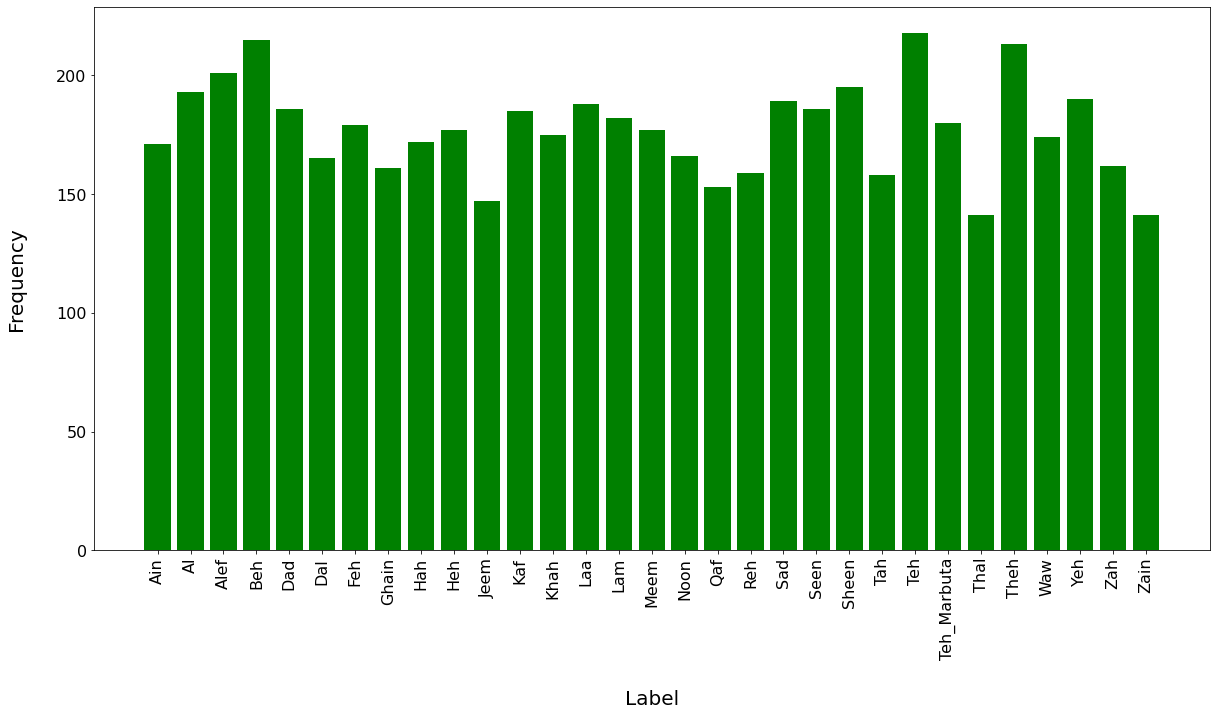

In [37]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

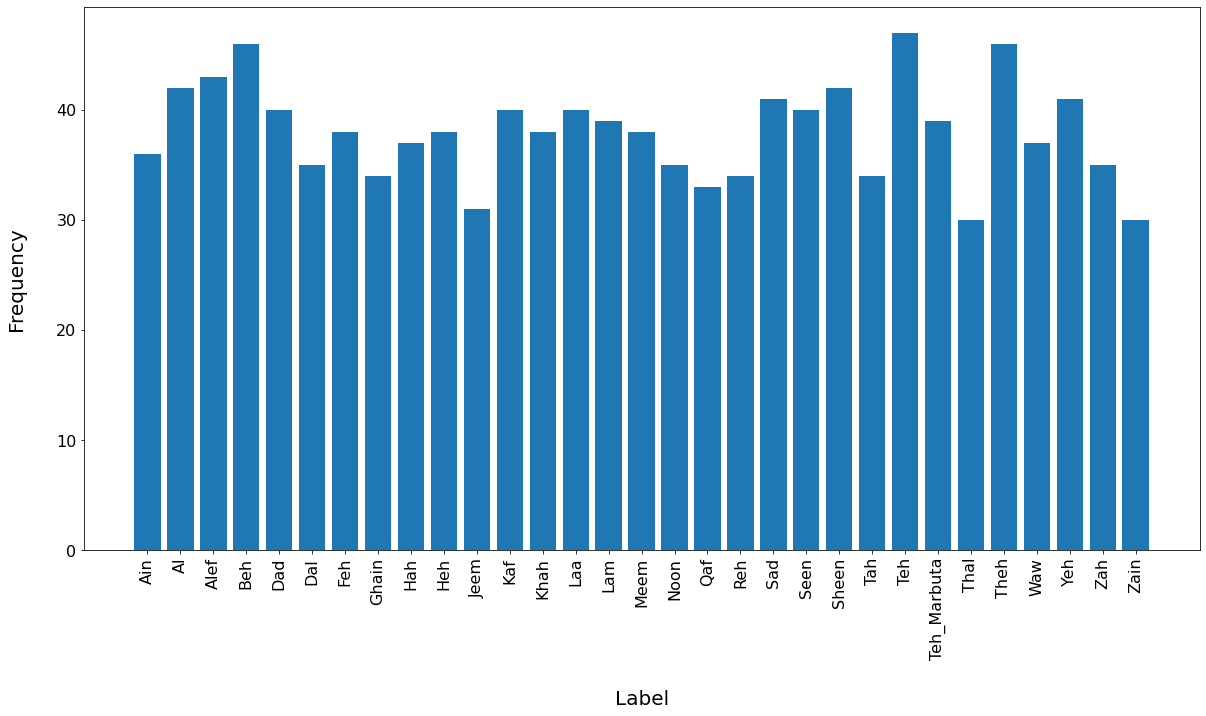

In [38]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

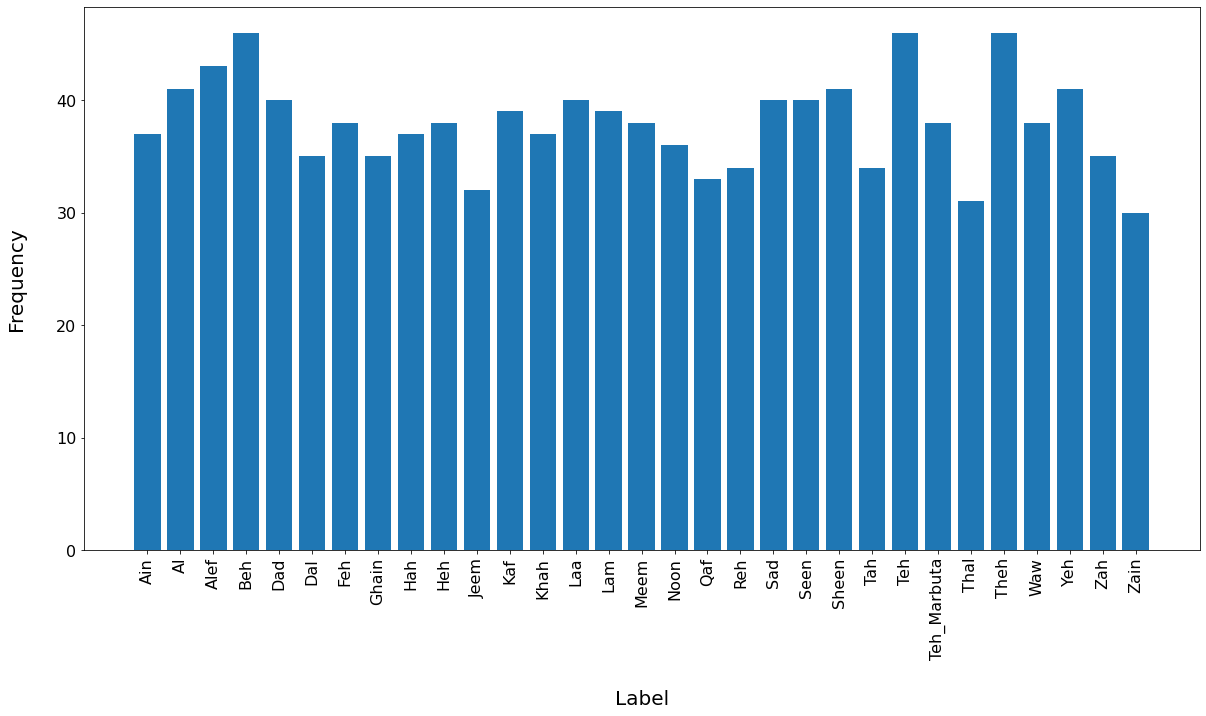

In [39]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [40]:
import torchvision.models as models
import torch.nn.functional as F

In [41]:
# Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/lenovo/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [42]:
model.classifier[6] 

Linear(in_features=4096, out_features=1000, bias=True)

In [43]:
num_of_output_classes = 31
# change the last conv2d layer
model.classifier[6] = nn.Conv2d(512, num_of_output_classes, kernel_size=(1, 1))
# change the internal num_classes variable rather than redefining the forward pass
model.num_classes = num_of_output_classes

In [44]:
model 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [45]:
class Model(nn.Module):

    def __init__(self, in_channels=3, num_class =31 ):
        super(Model, self).__init__()

        self.model = models.alexnet(pretrained=True)
        
#         for param in self.model.parameters():
#             param.requires_grad = False

        num_ftrs = self.model.classifier[6].in_features
        features = list(self.model.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_ftrs, num_class)])
        self.model.classifier = nn.Sequential(*features)
        print(self.model.classifier[6].out_features)

    def forward(self, x):
        return self.model(x)

model = Model()

31


In [46]:
# Move the model to the device
model.to(device)

Model(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): 

### Check the gradient of layers of ResNet-18

In [47]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

## Define a Loss function and optimizer

In [48]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.1)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [49]:
from tqdm import tqdm 

### Model training & Validation

In [50]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [51]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [52]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [53]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [54]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.12500000%




Epoch 1, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (inf --> nan).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 2, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 3, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 4/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 4, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 5, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 6, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 7, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 8, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 9, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 10/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 10, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 11/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 11, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 12/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 12, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 13/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 13, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 14/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 14, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 15, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 16, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 17/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 17, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 18, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 19/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 19, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 20/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 20, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 21/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 21, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 22/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 22, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 23, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 24/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 24, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 25/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 25, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 26/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 26, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 27/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 27, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 28, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 29/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 29, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 30/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 30, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 31/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 31, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 32/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 32, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 33/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 33, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 34/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 34, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 35, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 36/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 36, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 37/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 37, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 38/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 38, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 39/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 39, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 40/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 40, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 41/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 41, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 42/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 42, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 43/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 43, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 44/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 44, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 45/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 45, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 46/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 46, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 47/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 47, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 48/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 48, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 49/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 49, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 50/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 50, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 51/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 51, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 52/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 52, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 53/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 53, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 54/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 54, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 55/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 55, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 56/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 56, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 57/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 57, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 58/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 58, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 59/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 59, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 60/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 60, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 61/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 61, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 62/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 62, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 63/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 63, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 64/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 64, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 65/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 65, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 66/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 66, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 67/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 67, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 68/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 68, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 69/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 69, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 70/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 70, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 71/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 71, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 72/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 72, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 73/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 73, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 74/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 74, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 75/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 75, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 76/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 76, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 77/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 77, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 78/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 78, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 79/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 79, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 80/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 80, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 81/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 81, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 82/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 82, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 83/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 83, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 84/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 84, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 85/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 85, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 86/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 86, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 87/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 87, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 88/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 88, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 89/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 89, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 90/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 90, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 91/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 91, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 92/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 92, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 93/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 93, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 94/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 94, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 95/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 95, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 96/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 96, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 97/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 97, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 98/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 98, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 99/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 99, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 100/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 100, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 101/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 101, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 102/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 102, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 103/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 103, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 104/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 104, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 105/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 105, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 106/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 106, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 107/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 107, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 108/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 108, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 109/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 109, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 110/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 110, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 111/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 111, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 112/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 112, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 113/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 113, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 114/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 114, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 115/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 115, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 116/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 116, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 117/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 117, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 118/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 118, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 119/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 119, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 120/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 120, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 121/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 121, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 122/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 122, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 123/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 123, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 124/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 124, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 125/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 125, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 126/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 126, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 127/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 127, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 128/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 128, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 129/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 129, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 130/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 130, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 131/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 131, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 132/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 132, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 133/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 133, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 134/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 134, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 135/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 135, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 136/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 136, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 137/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 137, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 138/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 138, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 139/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 139, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 140/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 140, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 141/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 141, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 142/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 142, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 143/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 143, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 144/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 144, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 145/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 145, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 146/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 146, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 147/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 147, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 148/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 148, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 149/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 149, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 150/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 150, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 151/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 151, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 152/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 152, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 153/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 153, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 154/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 154, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 155/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 155, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 156/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 156, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 157/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 157, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 158/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 158, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 159/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 159, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 160/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 160, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 161/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 161, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 162/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 162, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 163/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 163, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 164/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 164, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 165/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 165, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 166/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 166, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 167/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 167, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 168/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 168, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 169/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 169, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 170/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 170, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 171/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 171, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 172/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 172, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 173/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 173, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 174/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 174, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 175/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 175, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 176/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 176, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 177/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 177, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 178/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 178, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 179/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 179, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 180/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 180, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 181/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 181, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 182/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 182, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 183/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 183, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 184/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 184, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 185/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 185, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 186/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 186, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 187/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 187, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 188/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 188, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 189/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 189, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 190/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 190, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 191/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 191, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 192/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 192, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 193/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 193, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 194/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 194, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 195/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 195, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 196/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 196, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 197/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 197, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 198/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 198, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 199/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 199, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 200/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 200, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 201/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 201, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 202/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 202, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 203/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 203, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 204/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 204, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 205/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 205, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 206/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 206, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 207/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 207, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 208/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 208, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 209/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 209, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 210/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 210, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 211/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 211, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 212/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 212, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 213/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 213, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 214/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 214, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 215/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 215, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 216/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 216, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 217/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 217, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 218/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 218, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 219/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 219, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 220/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 220, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 221/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 221, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 222/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 222, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 223/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 223, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 224/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 224, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 225/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 225, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 226/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 226, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 227/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 227, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 228/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 228, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 229/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 229, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 230/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 230, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 231/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 231, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 232/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 232, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 233/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 233, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 234/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 234, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 235/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 235, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 236/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 236, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 237/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 237, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 238/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 238, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 239/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 239, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 240/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 240, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 241/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 241, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 242/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 242, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 243/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 243, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 244/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 244, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 245/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 245, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 246/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 246, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 247/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 247, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 248/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 248, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 249/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 249, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 250/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 250, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 251/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 251, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 252/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 252, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 253/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 253, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 254/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 254, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 255/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 255, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 256/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 256, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 257/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 257, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 258/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 258, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 259/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 259, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 260/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 260, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 261/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 261, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 262/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 262, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 263/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 263, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 264/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 264, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 265/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 265, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 266/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 266, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 267/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 267, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 268/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 268, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 269/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 269, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 270/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 270, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 271/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 271, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 272/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 272, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 273/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 273, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 274/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 274, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 275/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 275, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 276/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 276, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 277/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 277, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 278/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 278, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 279/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 279, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 280/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 280, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 281/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 281, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 282/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 282, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 283/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 283, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 284/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 284, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 285/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 285, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 286/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 286, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 287/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 287, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 288/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 288, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 289/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 289, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 290/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 290, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 291/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 291, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 292/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 292, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 293/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 293, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 294/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 294, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 295/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 295, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 296/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 296, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 297/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 297, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 298/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 298, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 299/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 299, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...



Epoch 300/300,  Step [86/86], Avg training loss:  nan, Avg training accuracy :  3.10683139%




Epoch 300, Avg validation loss: nan, Avg validation accuracy : 3.41130607%

Validation loss decreased (nan --> nan).  Saving model ...


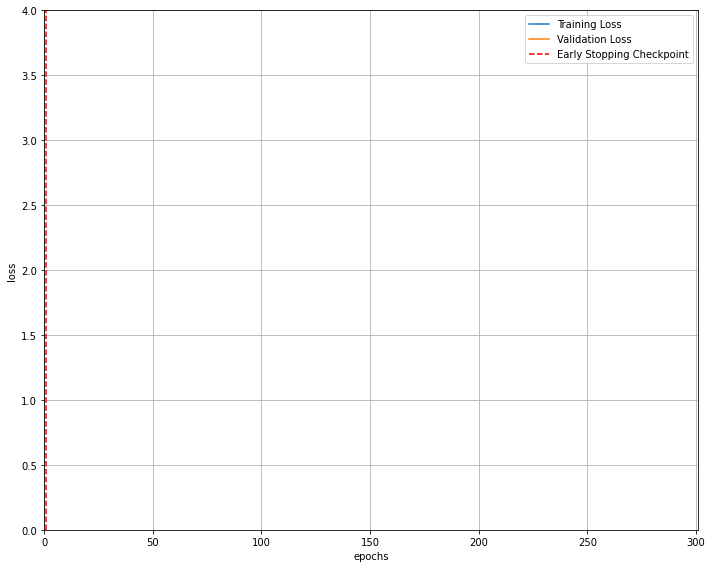

In [55]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [56]:
model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

31


FileNotFoundError: [Errno 2] No such file or directory: 'CheckPoints/alexnet_2'

### Testing loop

In [ ]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [ ]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()

In [ ]:
from sklearn import metrics


In [ ]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [ ]:
performance_matrix(true,pred, 'macro')

In [ ]:
performance_matrix(true,pred, 'micro')

In [ ]:
performance_matrix(true,pred, None)

In [ ]:
performance_matrix(true,pred, "weighted")

In [ ]:
count

In [ ]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

In [ ]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [ ]:
!mkdir images

In [ ]:
!ls

### Print fault images

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [ ]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

In [ ]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [ ]:
idx_to_class_dic

In [ ]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [ ]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [ ]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [ ]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
